In [27]:
import csv

# -- Constants -- #
DATA_FILE = '1915_2015_team_data_raw.csv'


# -- Helper Functions -- #
def read_data(path):
    data = []

    with open(path, 'r') as data_file:
        reader = csv.reader(data_file)
        headers = reader.next()

        for row in reader:
            row_data = {}
            for i in xrange(len(headers)):
                header = headers[i]
                value = row[i].strip()
                
                if value:
                    if '%' in header:
                        value = float(value.replace('%', '')) / 100
                    
                    elif 'Dol' in header:
                        value = float(value.replace('$', ''))
                
                    elif not value.replace(' ', '').isalpha():
                        value = float(value)
                    
                row_data[header] = value
                
            data.append(row_data)

    return data
        
data = read_data(DATA_FILE)


In [90]:
from scipy import stats
import tabulate

INDEPENDENT_VARS = ['HR', 'RBI', 'SB', 'BB%', 'K%', 'ISO', 'BABIP', 'AVG', 'OBP', 'SLG', 'wOBA', 'wRC+', 'BsR', 'PA']
CORRELATION_FIELDS = {'R': INDEPENDENT_VARS, 'Off': INDEPENDENT_VARS}

def get_series(data, key):
    return [d[key] for d in data]

def regressions(data):
    rows = []
    for first_field in CORRELATION_FIELDS:
        second_fields = CORRELATION_FIELDS[first_field]

        
        for second_field in second_fields:
            first_series = get_series(data, first_field) 
            second_series = get_series(data, second_field)
            regression = stats.linregress(second_series, first_series)
            
            rows.append([second_field, first_field, regression.rvalue, regression.rvalue ** 2, regression.slope, regression.intercept])

    rows.sort(key=lambda r: r[2], reverse=True)
    print tabulate.tabulate(rows, ('X', 'Y', 'r', 'r^2', 'm', 'b'))
    return [['X', 'Y', 'r', 'r^2', 'm', 'b']] + rows
            
rows = regressions(data)
with open('correlations.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerows(rows)

X      Y            r          r^2             m          b
-----  ---  ---------  -----------  ------------  ---------
RBI    R    0.98938    0.978872        0.994612     49.6913
wRC+   Off  0.984869   0.969968        7.42559    -741.41
SLG    R    0.84824    0.71951      2573.33       -309.678
wOBA   R    0.806042   0.649703     4417.75       -738.077
OBP    R    0.795775   0.633258     4898.67       -912.702
AVG    R    0.711877   0.506769     4934.8        -594.731
ISO    R    0.68907    0.474818     2682.05        350.667
BABIP  R    0.628053   0.394451     4506.01       -599.678
wRC+   R    0.624013   0.389392        7.17653      17.0241
PA     R    0.613102   0.375895        0.178197   -377.984
wOBA   Off  0.600191   0.36023      2156.58       -737.548
SLG    Off  0.576796   0.332694     1147.18       -485.705
RBI    Off  0.573209   0.328568        0.377776   -282.695
OBP    Off  0.565995   0.32035      2284.19       -787.548
HR     R    0.563703   0.317761        1.16739     55

In [54]:
import numpy
from sklearn import linear_model

FIELDS = ['HR', 'SB', 'AVG']
NEW_FIELDS = ['BABIP', 'SLG', 'OBP']

series = numpy.array([get_series(data, field) for field in FIELDS])
new_series = numpy.array([get_series(data, field) for field in NEW_FIELDS])

print numpy.linalg.lstsq(series.T, get_series(data, 'R'))
print numpy.linalg.lstsq(new_series.T, get_series(data, 'R'))
# series = series.T
# clf = linear_model.LinearRegression()
# clf.fit(series, get_series(data, 'R'))
# print clf.coef_, clf.intercept_

(array([  1.02784866e+00,   4.38139132e-02,   2.17685880e+03]), array([ 8608893.05075634]), 3, array([  7.49242754e+03,   2.21075768e+03,   3.59940037e+00]))
(array([-1830.67071013,  2179.33920042,  1136.17105685]), array([ 7423631.51527483]), 3, array([ 27.52657962,   0.86015201,   0.43223619]))


In [125]:
import pandas
import numpy
import statsmodels.api as sm

pandas_data = pandas.read_csv(DATA_FILE, index_col=(0,1))

old_x = pandas_data[['HR', 'AVG']]
y = pandas_data['R']

old_x = sm.add_constant(old_x)
old_est = sm.OLS(y, old_x).fit()
old_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     3995.
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               0.00
Time:                        19:13:47   Log-Likelihood:                -11627.
No. Observations:                2190   AIC:                         2.326e+04
Df Residuals:                    2187   BIC:                         2.328e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -679.5434     18.109    -37.526      0.000      -715.055  -644.031
HR             1.0940      0.021     53.223      0.000         1.054     1.134
AVG         4745.3216     68.807     68.966      0.000      4610.388  4880.255
==============================================================================
Omnibus:                      386.951   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1356.689
Skew:                          -0.855   Prob(JB):                    2.50e-295
Kurtosis:                       6.456   Cond. No.                     9.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [122]:
new_x = pandas_data[['SLG', 'OBP']]
new_x = sm.add_constant(new_x)
new_est = sm.OLS(y, new_x).fit()
new_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     4587.
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               0.00
Time:                        19:13:32   Log-Likelihood:                -11507.
No. Observations:                2190   AIC:                         2.302e+04
Df Residuals:                    2187   BIC:                         2.304e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -802.1563     19.184    -41.814      0.000      -839.777  -764.535
SLG         1732.8045     38.950     44.488      0.000      1656.422  1809.187
OBP         2498.5034     79.035     31.613      0.000      2343.513  2653.494
==============================================================================
Omnibus:                     1203.332   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11153.357
Skew:                          -2.445   Prob(JB):                         0.00
Kurtosis:                      12.915   Cond. No.                         96.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

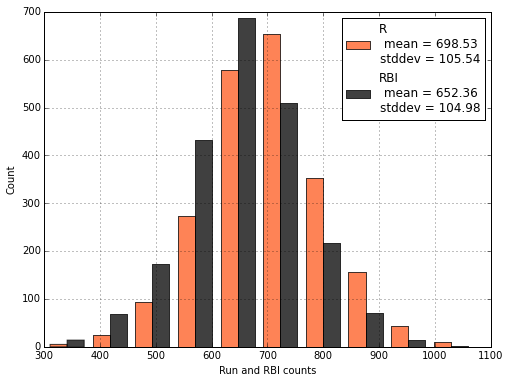

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (8,6), dpi = 400)

r = np.array(get_series(data, 'R'))
rbi = np.array(get_series(data, 'RBI'))

# plt.hist([greenland_ice_mass, antarctica_ice_mass], np.linspace(-2500,2000,9), color=['green', '#74BBFB'], alpha=0.75)
plt.hist([r, rbi], color=['#FE5A1D', 'black'], alpha=0.75)

r_mean = np.mean(r)
r_stddev = np.std(r)
r_label = 'R\n mean = {mean:.2f}\nstddev = {stddev:.2f}'\
    .format(mean = r_mean, stddev=r_stddev)

rbi_mean = np.mean(rbi)
rbi_stddev = np.std(rbi)
rbi_label = 'RBI\n mean = {mean:.2f}\nstddev = {stddev:.2f}'\
    .format(mean = rbi_mean, stddev=rbi_stddev)
    
plt.legend([r_label, rbi_label], loc='best')
plt.xlabel('Run and RBI counts')
plt.ylabel('Count')
plt.grid(True)
plt.show()


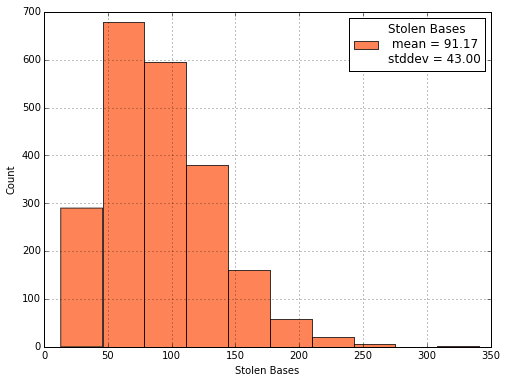

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (8,6), dpi = 400)

sb = np.array(get_series(data, 'SB'))

# plt.hist([greenland_ice_mass, antarctica_ice_mass], np.linspace(-2500,2000,9), color=['green', '#74BBFB'], alpha=0.75)
plt.hist([sb], color=['##'], alpha=0.75)

sb_mean = np.mean(sb)
sb_stddev = np.std(sb)
sb_label = 'Stolen Bases\n mean = {mean:.2f}\nstddev = {stddev:.2f}'\
    .format(mean = sb_mean, stddev=sb_stddev)
   
plt.legend([sb_label], loc='best')
plt.xlabel('Stolen Bases')
plt.ylabel('Count')
plt.grid(True)
plt.show()

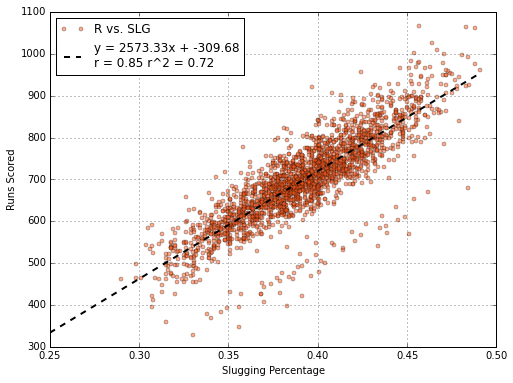

In [113]:
plt.figure(figsize = (8,6), dpi = 400)

slg = np.array(get_series(data, 'SLG'))
r = np.array(get_series(data, 'R'))

reg = stats.linregress(slg, r)
reg_x = np.linspace(0.25, 0.49, 50)

# plt.plot(np.linspace(2002,2016, 100), np.linspace(2002,2016, 100) * 0, color='black')
plt.plot(slg, r, 'o', color='#FE5A1D', label='R vs. SLG', markersize=4, alpha=0.5)
reg_label = 'y = {m:.2f}x + {b:.2f}\nr = {r:.2f} r^2 = {r2:.2f}'\
    .format(m=reg.slope, b=reg.intercept, r=reg.rvalue, r2=reg.rvalue ** 2)
plt.plot(reg_x, reg.slope * reg_x + reg.intercept, '--', color='black', label=reg_label, linewidth=2)

# plt.plot(reg_x, reg.slope * reg_x + reg.intercept - 125, '--', color='blue', label=reg_label, linewidth=2)

plt.grid(True)
plt.xlabel('Slugging Percentage')
plt.ylabel('Runs Scored')
plt.legend(loc = 'best')

LinregressResult(slope=2601.6828191183135, intercept=-315.14643770279122, rvalue=0.89813747826296031, pvalue=0.0, stderr=27.592487129162251)


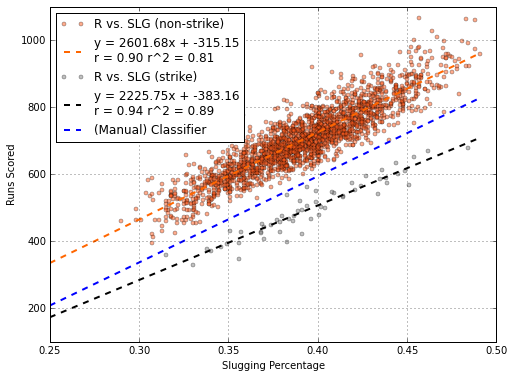

In [117]:
plt.figure(figsize = (8,6), dpi = 400)

slg = np.array(get_series(data, 'SLG'))
r = np.array(get_series(data, 'R'))
zipped = zip(slg, r)

non_strike = [x for x in zipped if x[1]-2573.33*x[0] + 435 > 0]
non_slg, non_r = zip(*non_strike)

strike = [x for x in zipped if x[1]-2573.33*x[0] + 435 <= 0]
strike_slg, strike_r = zip(*strike)

reg_x = np.linspace(0.25, 0.49, 50)
non_reg = stats.linregress(non_slg, non_r)
print non_reg
strike_reg = stats.linregress(strike_slg, strike_r)

# plt.plot(np.linspace(2002,2016, 100), np.linspace(2002,2016, 100) * 0, color='black')
plt.plot(non_slg, non_r, 'o', color='#FE5A1D', label='R vs. SLG (non-strike)', markersize=4, alpha=0.5)
non_reg_label = 'y = {m:.2f}x + {b:.2f}\nr = {r:.2f} r^2 = {r2:.2f}'\
    .format(m=non_reg.slope, b=non_reg.intercept, r=non_reg.rvalue, r2=non_reg.rvalue ** 2)
plt.plot(reg_x, non_reg.slope * reg_x + non_reg.intercept, '--', color='#FF6600', label=non_reg_label, linewidth=2)

plt.plot(strike_slg, strike_r, 'o', color='gray', label='R vs. SLG (strike)', markersize=4, alpha=0.5)
strike_reg_label = 'y = {m:.2f}x + {b:.2f}\nr = {r:.2f} r^2 = {r2:.2f}'\
    .format(m=strike_reg.slope, b=strike_reg.intercept, r=strike_reg.rvalue, r2=strike_reg.rvalue ** 2)
plt.plot(reg_x, strike_reg.slope * reg_x + strike_reg.intercept, '--', color='black', label=strike_reg_label, linewidth=2)

classifier_m = 2573.33
classifier_b = -435
c = '(Manual) Classifier'
plt.plot(reg_x, classifier_m * reg_x + classifier_b, '--', color='blue', label=classifier_label, linewidth=2)

plt.grid(True)
plt.xlabel('Slugging Percentage')
plt.ylabel('Runs Scored')
plt.legend(loc = 'upper left')

In [119]:
new_x = pandas_data[['SLG', 'PA']]
new_x = sm.add_constant(new_x)
new_est = sm.OLS(y, new_x).fit()
new_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     5946.
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               0.00
Time:                        19:05:07   Log-Likelihood:                -11272.
No. Observations:                2190   AIC:                         2.255e+04
Df Residuals:                    2187   BIC:                         2.257e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -820.9868     15.796    -51.976      0.000      -851.963  -790.011
SLG         2199.4917     27.074     81.240      0.000      2146.398  2252.585
PA             0.1089      0.003     41.977      0.000         0.104     0.114
==============================================================================
Omnibus:                      147.141   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.746
Skew:                           0.631   Prob(JB):                     2.08e-40
Kurtosis:                       3.640   Cond. No.                     1.89e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""